# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import itertools
import keras
import keras_tuner as kt
import xgboost as xgb

from random import gauss
from random import seed

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error,r2_score

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from arch import arch_model

from pmdarima import auto_arima
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import Hyperband
from keras.models import load_model,Sequential

In [3]:
df = pd.read_csv('../data/cleaned_data/master.csv',index_col=0)
df.head()

,nonglu_price,hommali_price,agri_prod_index,crops_prod_index,paddy_prod_index,nonglu_prod_index,hommali_prod_index,agri_price_index,crops_price_index,paddy_price_index,...,water_station_M7,water_station_N1,water_station_N67,water_station_Ny1B,water_station_P1,water_station_P17,water_station_S4B,water_station_Sw5A,water_station_Y17,water_station_Y1C
date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,6696.0,7628.0,109.703894,114.011647,43.580672,72.649707,8.077559,110.377654,113.821771,100.581118,...,140.50,66.17,520.00,26.85,38.96,679.63,6.23,97.92,1.24,20.25
2006-02-01,6633.0,7873.0,93.049409,91.755084,46.062229,85.832560,0.000000,111.337228,115.390439,101.563145,...,87.75,39.02,501.32,26.22,64.11,573.91,4.69,69.55,0.00,13.07
2006-03-01,6649.0,7960.0,92.803780,87.828340,74.516499,138.854375,0.000000,112.498075,117.876876,103.063764,...,108.95,20.94,558.72,42.23,68.26,523.38,2.23,60.02,2.32,35.51
2006-04-01,6880.0,8028.0,75.452369,67.662286,66.215260,123.385807,0.000000,115.595159,121.878356,104.906097,...,188.40,45.73,692.79,61.08,84.68,508.65,0.06,76.80,5.84,31.54
2006-05-01,6782.0,8069.0,77.366260,68.992476,35.785484,66.682829,0.000000,113.408937,119.725058,104.687875,...,270.30,94.19,1027.25,44.98,146.19,1092.68,34.64,88.76,168.17,268.37


In [4]:
# Set index as datetime
df.index = pd.to_datetime(df.index,format="%Y-%m-%d")

In [5]:
# Check type of value
df.dtypes.value_counts()

float64    49
Name: count, dtype: int64

In [6]:
df.columns

Index(['nonglu_price', 'hommali_price', 'agri_prod_index', 'crops_prod_index',
       'paddy_prod_index', 'nonglu_prod_index', 'hommali_prod_index',
       'agri_price_index', 'crops_price_index', 'paddy_price_index',
       'nonglu_price_index', 'hommali_price_index', 'agri_export_value',
       'rice_export_value', 'ricet_export_amount', 'cpi', 'cpi_rice',
       'pol_rate', 'neer', 'reer', 'sirikit_water', 'bhumibol_water',
       'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4',
       'fertilizer_5', 'fertilizer_6', 'water_station_B10',
       'water_station_C13', 'water_station_C2', 'water_station_G8',
       'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
       'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
       'water_station_M6A', 'water_station_M7', 'water_station_N1',
       'water_station_N67', 'water_station_Ny1B', 'water_station_P1',
       'water_station_P17', 'water_station_S4B', 'water_station_Sw5A',
       'water_

In [7]:
df.shape

(226, 49)

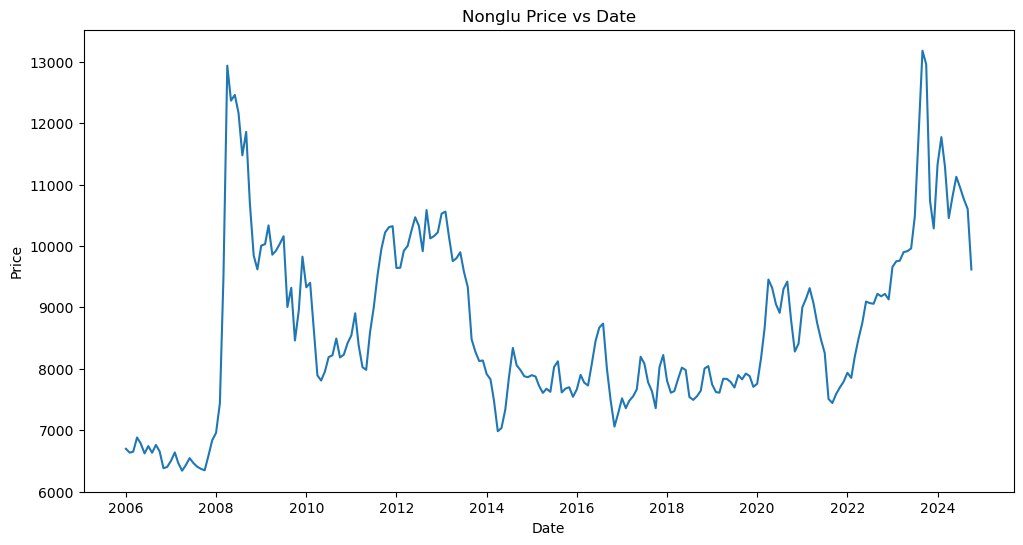

In [8]:
#plot the "nonglu_price" column vs date to see the trend
plt.figure(figsize=(12,6))
plt.plot(df['nonglu_price'])
plt.title('Nonglu Price vs Date')
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

# Stationarity Check

In [10]:
result = adfuller(df['nonglu_price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -3.302824716654775
p-value: 0.014752680770463844
Critical Values:
   1%: -3.4604283689894815
   5%: -2.874768966942149
   10%: -2.57382076446281


In [11]:
# ADF Statistic = -3.303
# A highly negative value generally indicates evidence against the null hypothesis 
# (non-stationarity). However, the magnitude alone is not the only determinant; 
# the test's critical values must also be considered for confirmation.

# More negative than both the 5% (-2.875) and 10% (-2.574) critical values
# But not more negative than the 1% critical value (-3.460)
# This means one can reject the null hypothesis of non-stationarity at the 5% confidence level 
# (which we're using down below) but not at the 1% level (which is basically fine here)
# The p-value of 0.015 confirms this, as it's less than 0.05 but greater than 0.01

# p-value = 0.015
# This is less than the standard 0.05 significance level
# Therefore, we reject the null hypothesis of non-stationarity
# This output justifies rejecting the null hypothesis that the series is non-stationary.

# Adds some features

In [13]:
import warnings
warnings.filterwarnings("ignore")

# Calculate ratio between current price and 6-month moving average to possibly detect unusual acceleration
# Likely the most viable and valuable of the options listed
df['price_vs_6ma'] = df['nonglu_price'] / df['nonglu_price'].rolling(6).mean()

# Add lagged fertilizer prices to possibly catch early price pressure signals
# Might be noisy due to long lead time - could be adjusted?
df['fert1_lag6m'] = df['fertilizer_1'].shift(6)

# Calculate month-over-month percent changes for grain prices to possibly capture rapid market shifts
# Could be quite noisy and act more as a lagging indicator than a leading indicator
df['nonglu_mom'] = df['nonglu_price'].pct_change()
df['hommali_mom'] = df['hommali_price'].pct_change() 
df['paddy_mom'] = df['paddy_price_index'].pct_change()

# Impute NaN 
df['price_vs_6ma'].fillna(df['price_vs_6ma'].iloc[7],inplace=True)
df['fert1_lag6m'].fillna(df['fert1_lag6m'].iloc[7],inplace=True)
df['nonglu_mom'].fillna(df['nonglu_mom'].iloc[1],inplace=True)
df['hommali_mom'].fillna(df['hommali_mom'].iloc[1],inplace=True)
df['paddy_mom'].fillna(df['paddy_mom'].iloc[1],inplace=True)

# Model

In [15]:
# Create the target
y = df['nonglu_price']

# Define independent variables (predictors) X

# take hommali_price, paddy_price_index, cpi_rice out 
# and add 'price_vs_6ma','price_vs_6ma', 'fert1_lag6m','nonglu_mom', 'hommali_mom', 'paddy_mom'
xvars = ['agri_prod_index', 'crops_prod_index','paddy_prod_index', 
         'nonglu_prod_index', 'hommali_prod_index',
         'agri_price_index', 'crops_price_index', 'agri_export_value', 
         'ricet_export_amount', 'cpi',
         'pol_rate', 'neer', 'reer', 'sirikit_water', 'bhumibol_water',
         'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4','fertilizer_5', 'fertilizer_6',
         'water_station_B10', 
         'water_station_C13', 'water_station_C2', 'water_station_G8',
         'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
         'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
         'water_station_M6A', 'water_station_M7', 'water_station_N1',
         'water_station_N67', 'water_station_Ny1B', 
         'water_station_P1','water_station_P17',
         'water_station_S4B', 'water_station_Sw5A',
         'water_station_Y17', 'water_station_Y1C',
         'price_vs_6ma', 'fert1_lag6m','nonglu_mom', 'hommali_mom', 'paddy_mom']


# Adjust X to match the same periods
X = df[xvars]

In [16]:
# Split data into training and test sets
# shuffle=False maintains time order (crucial for time series!)
# test_size=20 reserves last 20 observations for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=25)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 47), (25, 47), (201,), (25,))

In [17]:
X_train['shock_event'] = [1 if date >= pd.to_datetime('2023-12-01') else 0 for date in y_train.index]
X_test['shock_event'] = [1 if date >= pd.to_datetime('2023-12-01')  else 0 for date in y_test.index]

# If the sharp drop can be explained through existing exogenous variables or lagged 
# effects, a shock variable may not add significant predictive value.
# If the drop reflects a unique, external event, the shock variable might be the key 
# to improving forecasts.

## 1. Linear Regression Model

### Model 1: Linear Regression Model

In [20]:
label = 'nonglu_price'
df = df[xvars + [label]]

train_data = df[df.index < '2023-01-01']
test_data = df[df.index >= '2023-01-01']

X_train = train_data.drop(columns=['nonglu_price'])
y_train = train_data['nonglu_price']

X_test = test_data.drop(columns=['nonglu_price'])
y_test = test_data['nonglu_price']

In [21]:
# Instantiate and fit an Linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((204, 47), (22, 47), (204,), (22,))

In [23]:
# Prediction
y_pred = lr.predict(X_test)

In [24]:
# Evaluate the Linear Regression Model
lr_mse = mean_squared_error(y_test, y_pred)
lr_rmse = root_mean_squared_error(y_test, y_pred)
lr_r2 = r2_score(y_test, y_pred)
print(f"Linear Regression Model MSE: {lr_mse:.4f}")
print(f"Linear Regression Model RMSE: {lr_rmse:.4f}")
print(f"Linear Regression Model R-squared: {lr_r2:.4f}")

Linear Regression Model MSE: 1230137.0844
Linear Regression Model RMSE: 1109.1155
Linear Regression Model R-squared: -0.3069


In [25]:
# Create Accuracy Dataframe
lr_accuracy = pd.DataFrame(data = {'model': ['Linear'] * 3,
                                   'accuracy':['MSE','RMSE','R2'],'score':[lr_mse,lr_rmse,lr_r2]})
lr_accuracy

,model,accuracy,score
0,Linear,MSE,1.230137e+06
1,Linear,RMSE,1.109115e+03
2,Linear,R2,-3.069252e-01


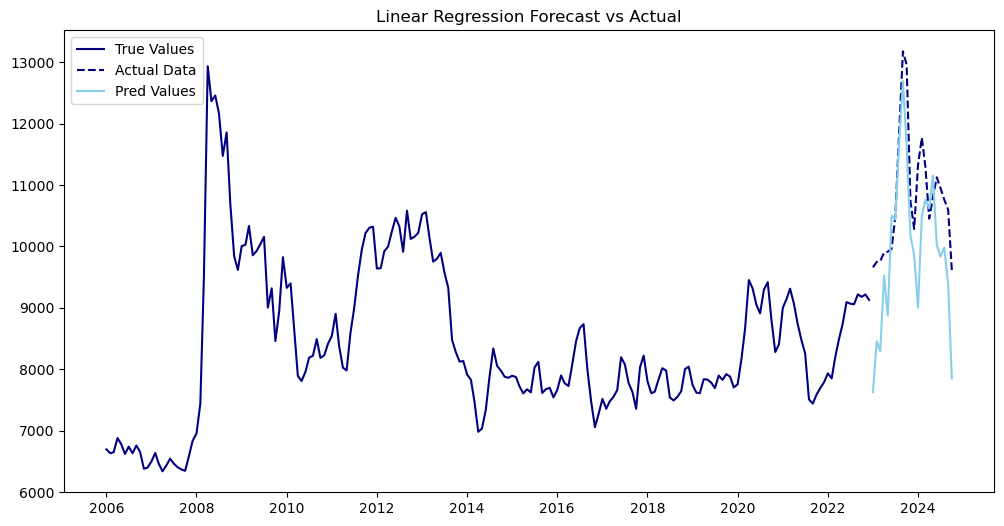

<Figure size 640x480 with 0 Axes>

In [26]:
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(test_data.index,y_pred, c='skyblue', label='Pred Values')
plt.title("Linear Regression Forecast vs Actual")
plt.legend()
plt.show()
# saving the plot as an image
plt.savefig('../figure/Linear Regression Forecast vs Actual.png')
plt.show()

#### Feature importance

In [28]:
#print regression coefficients
pd.DataFrame(zip(X.columns, lr.coef_))

,0,1
0,agri_prod_index,13.982617
1,crops_prod_index,-6.047616
2,paddy_prod_index,-4.152784
3,nonglu_prod_index,1.762884
4,hommali_prod_index,1.031566
5,agri_price_index,-125.289810
6,crops_price_index,100.400469
7,agri_export_value,0.804586
8,ricet_export_amount,-0.002035
9,cpi,38.922857


## 2. ARIMA Model

### Model 2 : ARIMA

In [31]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax1_model = ARIMA(
    y_train,                 # Dependent variable (nonglu_price)
    exog=X_train,            # External variables 
    order=(2, 1, 2)).fit()   # ARIMA parameters: (p=2, d=1, q=2)

In [32]:
# Generate predictions on the test set
arimax1_forecast = arimax1_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [33]:
# Evaluate the ARIMAX(2,1,2) Model
arimax1_mse = mean_squared_error(y_test, arimax1_forecast)
arimax1_rmse = root_mean_squared_error(y_test, arimax1_forecast)
arimax1_r2 = r2_score(y_test, arimax1_forecast)
print(f"ARIMAX(2,1,2) Model MSE : {arimax1_mse:.4f}")
print(f"ARIMAX(2,1,2) Model RMSE :{arimax1_rmse:.4f}")
print(f"ARIMAX(2,1,2) Model R-squared :{arimax1_r2:.4f}")

ARIMAX(2,1,2) Model MSE : 3553593.8562
ARIMAX(2,1,2) Model RMSE :1885.0978
ARIMAX(2,1,2) Model R-squared :-2.7754


In [34]:
# Create Accuracy Dataframe
arimax1_accuracy = pd.DataFrame(data = {'model': ['ARIMAX(2,1,2)'] * 3,
                                'accuracy':['MSE','RMSE','R2'],'score':[arimax1_mse,arimax1_rmse,arimax1_r2]})
arimax1_accuracy

,model,accuracy,score
0,"ARIMAX(2,1,2)",MSE,3.553594e+06
1,"ARIMAX(2,1,2)",RMSE,1.885098e+03
2,"ARIMAX(2,1,2)",R2,-2.775418e+00


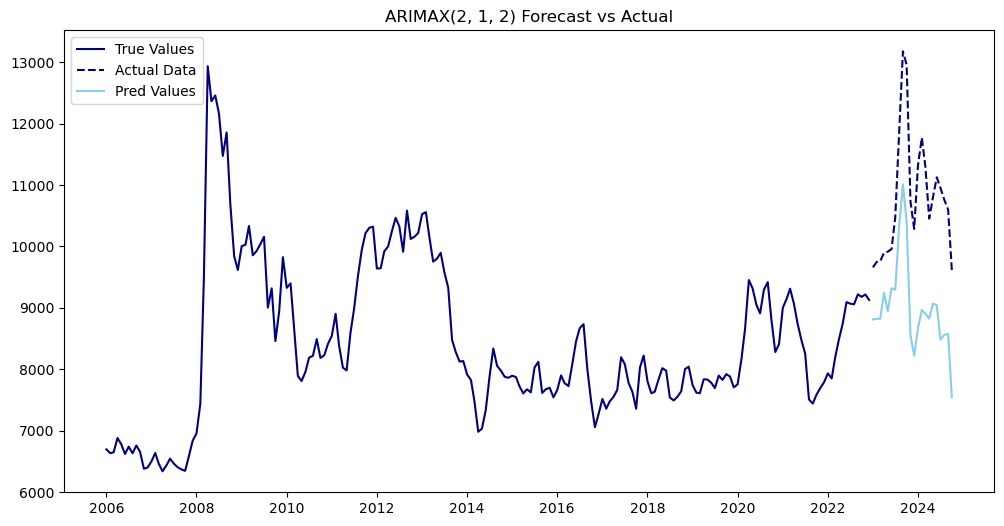

In [35]:
# Plot 
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax1_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2, 1, 2) Forecast vs Actual")
plt.legend()
# saving the plot as an image
plt.savefig('../figure/ARIMAX(2,1,2) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [37]:
arimax1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  204
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1293.917
Date:                Wed, 18 Dec 2024   AIC                           2691.834
Time:                        10:49:25   BIC                           2864.120
Sample:                    01-01-2006   HQIC                          2761.534
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
agri_prod_index         0.0613      7.261      0.008      0.993     -14.170      14.292
crops_prod_index        1.0113      5.601      0.181      0.857      -9.967      11.990
paddy_prod_index       -0.1474      1.494     -0.099      0.921      -3.076       2.781
nonglu_prod_index      -0.2242      1.032     -0.217      0.828      -2.248       1.799
hommali_prod_index     -0.0562      0.557     -0.101      0.920      -1.148       1.036
agri_price_index      -39.9261     30.014     -1.330      0.183     -98.752      18.900
crops_price_index      34.1138     22.221      1.535      0.125      -9.438      77.666
agri_export_value       0.2326      0.121      1.923      0.055      -0.005       0.470
ricet_export_amount    -0.0002      0.000     -1.685      0.092      -0.000    3.37e-05
cpi                    14.0281     83.947      0.167      0.867    -150.504     178.560
pol_rate               90.4696    206.371      0.438      0.661    -314.009     494.949
neer                  -54.9008     78.793     -0.697      0.486    -209.333      99.531
reer                   54.8102     80.163      0.684      0.494    -102.307     211.928
sirikit_water           0.0392      0.289      0.136      0.892      -0.527       0.605
bhumibol_water          0.0968      0.094      1.029      0.303      -0.087       0.281
fertilizer_1           -0.0545      0.051     -1.062      0.288      -0.155       0.046
fertilizer_2           -0.0016      0.039     -0.041      0.967      -0.077       0.074
fertilizer_3            0.0318      0.045      0.705      0.481      -0.057       0.120
fertilizer_4            0.0033      0.022      0.151      0.880      -0.040       0.046
fertilizer_5            0.0748      0.046      1.616      0.106      -0.016       0.165
fertilizer_6           -0.0118      0.030     -0.392      0.695      -0.071       0.047
water_station_B10      -0.1284      0.552     -0.233      0.816      -1.209       0.953
water_station_C13       0.0366      0.054      0.684      0.494      -0.068       0.142
water_station_C2       -0.0037      0.083     -0.044      0.965      -0.166       0.159
water_station_G8       -0.3317      0.781     -0.425      0.671      -1.862       1.199
water_station_K10      -0.0772      0.123     -0.626      0.531      -0.319       0.164
water_station_K11A     -0.0361      0.090     -0.400      0.689      -0.213       0.141
water_station_Kgt3      0.2161      0.099      2.177      0.029       0.022       0.411
water_station_Kh103     1.2038      1.099      1.095      0.273      -0.950       3.358
water_station_Kh58A    -0.2881      0.248     -1.163      0.245      -0.774       0.198
water_station_Kh72      1.2372      1.803      0.686      0.492      -2.296       4.770
water_station_M6A       0.0207      0.058      0.356      0.722      -0.093       0.135
water_station_M7       -0.0129      0.023     -0.561      0.575      -0.058       0.032
water_station_N1       -0.0575      0.370     -0.155      0.876      -0.7

### Model 3 : Auto ARIMA

In [39]:
# Automatically tune ARIMA parameters
auto_model = auto_arima(
    y_train,exogenous=X_train,
    start_p=0, max_p=4,
    start_q=0, max_q=4,
    d=None,seasonal=False, trace=False,error_action='ignore', suppress_warnings=True, stepwise=True)

# Best parameters
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  204
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1518.392
Date:                Wed, 18 Dec 2024   AIC                           3044.784
Time:                        10:49:25   BIC                           3058.057
Sample:                    01-01-2006   HQIC                          3050.153
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    675.3785    215.699      3.131      0.002     252.615    1098.142
ar.L1          1.2124      0.030     40.094      0.000       1.153       1.272
ar.L2         -0.2929      0.037     -7.909      0.0

In [40]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax2_model = ARIMA(
    y_train,           # Dependent variable (nonglu_price)
    exog = X_train,    # External variables 
    order = (2, 0, 0), # ARIMA parameters: (p=2, d=0, q=0)
).fit()

# Get the residual
arimax2_model_residuals = arimax2_model.resid

# Generate predictions on the test set
arimax2_forecast = arimax2_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [41]:
# Evaluate the ARIMAX(2,0,0) Model
arimax2_mse = mean_squared_error(y_test, arimax2_forecast)
arimax2_rmse = root_mean_squared_error(y_test, arimax2_forecast)
arimax2_r2 = r2_score(y_test, arimax2_forecast)
print(f"ARIMAX(2,0,0) Model MSE : {arimax2_mse:.4f}")
print(f"ARIMAX(2,0,0) Model RMSE :{arimax2_rmse:.4f}")
print(f"ARIMAX(2,0,0) Model R-squared :{arimax2_r2:.4f}")

ARIMAX(2,0,0) Model MSE : 1275763.1376
ARIMAX(2,0,0) Model RMSE :1129.4969
ARIMAX(2,0,0) Model R-squared :-0.3554


In [42]:
# Create Accuracy Dataframe
arimax2_accuracy = pd.DataFrame(data = {'model': ['ARIMAX(2,0,0)'] * 3,
                                'accuracy':['MSE','RMSE','R2'],'score':[arimax2_mse,arimax2_rmse,arimax2_r2]})
arimax2_accuracy

,model,accuracy,score
0,"ARIMAX(2,0,0)",MSE,1.275763e+06
1,"ARIMAX(2,0,0)",RMSE,1.129497e+03
2,"ARIMAX(2,0,0)",R2,-3.553993e-01


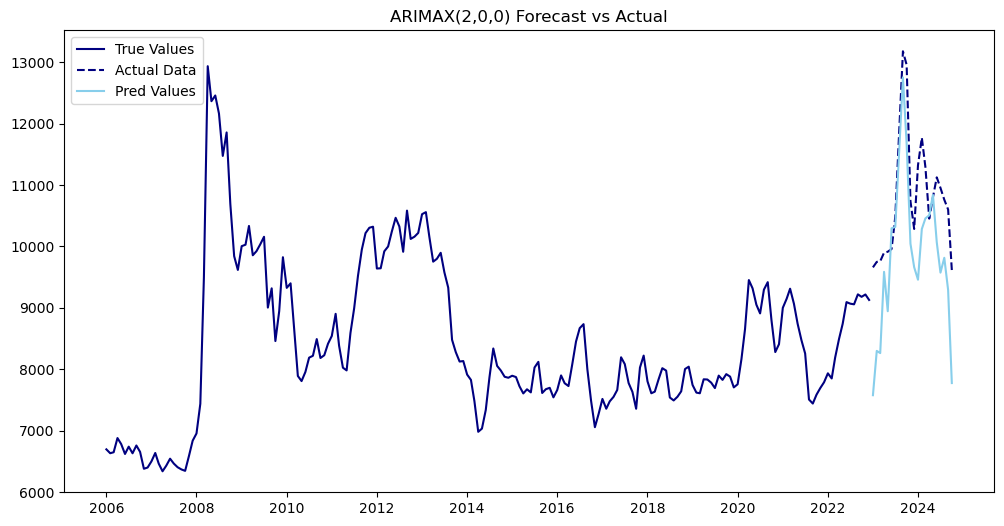

<Figure size 640x480 with 0 Axes>

In [43]:
# Plot 
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax2_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2,0,0) Forecast vs Actual")
plt.legend()
plt.show()
# saving the plot as an image
plt.savefig('../figure/ARIMAX(2,0,0) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [45]:
arimax2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  204
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1455.044
Date:                Wed, 18 Dec 2024   AIC                           3012.088
Time:                        10:49:36   BIC                           3181.312
Sample:                    01-01-2006   HQIC                          3080.542
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5618.2744   3027.163     -1.856      0.063   -1.16e+04     314.857
agri_prod_index        13.9743     24.016      0.582      0.561     -33.096      61.045
crops_prod_index       -6.0582     17.252     -0.351      0.725     -39.871      27.755
paddy_prod_index       -4.1735      3.592     -1.162      0.245     -11.214       2.867
nonglu_prod_index       1.7511      2.359      0.742      0.458      -2.872       6.374
hommali_prod_index      0.9911      1.269      0.781      0.435      -1.495       3.477
agri_price_index     -125.2905     37.968     -3.300      0.001    -199.706     -50.875
crops_price_index     100.3995     28.380      3.538      0.000      44.775     156.024
agri_export_value       0.7484      0.247      3.030      0.002       0.264       1.233
ricet_export_amount    -0.0012      0.000     -3.422      0.001      -0.002      -0.000
cpi                    38.9217     38.919      1.000      0.317     -37.357     115.201
pol_rate               32.8637    206.501      0.159      0.874    -371.871     437.599
neer                  -49.9110     42.493     -1.175      0.240    -133.195      33.373
reer                   40.3446     46.667      0.865      0.387     -51.121     131.811
sirikit_water          -0.1795      0.728     -0.246      0.805      -1.607       1.248
bhumibol_water          0.2690      0.277      0.971      0.331      -0.274       0.812
fertilizer_1           -0.0161      0.105     -0.153      0.878      -0.222       0.189
fertilizer_2           -0.1128      0.063     -1.786      0.074      -0.237       0.011
fertilizer_3            0.0953      0.105      0.905      0.365      -0.111       0.302
fertilizer_4            0.0740      0.056      1.318      0.188      -0.036       0.184
fertilizer_5            0.1364      0.119      1.149      0.251      -0.096       0.369
fertilizer_6            0.0059      0.108      0.054      0.957      -0.206       0.218
water_station_B10      -2.0644      1.373     -1.503      0.133      -4.756       0.627
water_station_C13       0.2875      0.159      1.806      0.071      -0.025       0.600
water_station_C2       -0.3634      0.233     -1.563      0.118      -0.819       0.092
water_station_G8        0.6787      2.679      0.253      0.800      -4.572       5.930
water_station_K10       0.2764      0.338      0.818      0.413      -0.386       0.939
water_station_K11A     -0.3662      0.292     -1.253      0.210      -0.939       0.207
water_station_Kgt3      0.8115      0.265      3.059      0.002       0.292       1.331
water_station_Kh103     2.6901      3.271      0.823      0.411      -3.720       9.100
water_station_Kh58A    -0.5439      0.900     -0.604      0.546      -2.308       1.220
water_station_Kh72     -3.0302      4.279     -0.708      0.479     -11.417       5.357
water_station_M6A       0.1473      0.168      0.879      0.379      -0.181       0.476
water_station_M7       -0.0168      0.062     -0.272      0.785      -0.1

## 4. GARCH Model

### Model 4 : GARCH

In [48]:
# Seed pseudorandom number generator
seed(1)

# Define model - fit on the residuals.
garch_model = arch_model(arimax2_model_residuals,mean='HARX', vol='GARCH', p=1, q=1, rescale=False)

# Fit model
garch_model_fit = garch_model.fit(disp='off')

# forecast the test set
garch_forecast = garch_model_fit.forecast(horizon=len(y_test), reindex=False)
garch_volatility = np.sqrt(garch_forecast.variance.values[-1])  # Convert to standard deviation

arimax_forecast = arimax2_model.get_forecast(steps=len(y_test), exog=X_test)
arimax_mean = arimax_forecast.predicted_mean

# combine ARIMAX Mean and GARCH Volatility
yhat = arimax_mean + garch_volatility  # Add GARCH volatility directly

In [49]:
# Evaluate the GARCH Model
garch_mse = mean_squared_error(y_test, yhat)
garch_rmse = root_mean_squared_error(y_test, yhat)
garch_r2 = r2_score(y_test, yhat)
print(f"GARCH Model MSE : {garch_mse:.4f}")
print(f"GARCH Model RMSE :{garch_rmse:.4f}")
print(f"GARCH Model R-squared :{garch_r2:.4f}")

GARCH Model MSE : 810668.4448
GARCH Model RMSE :900.3713
GARCH Model R-squared :0.1387


In [50]:
# Create Accuracy Dataframe
garch_accuracy = pd.DataFrame(data = {'model': ['GARCH '] * 3,
                                'accuracy':['MSE','RMSE','R2'],'score':[garch_mse,garch_rmse,garch_r2]})
garch_accuracy

,model,accuracy,score
0,GARCH,MSE,810668.444769
1,GARCH,RMSE,900.371282
2,GARCH,R2,0.138728


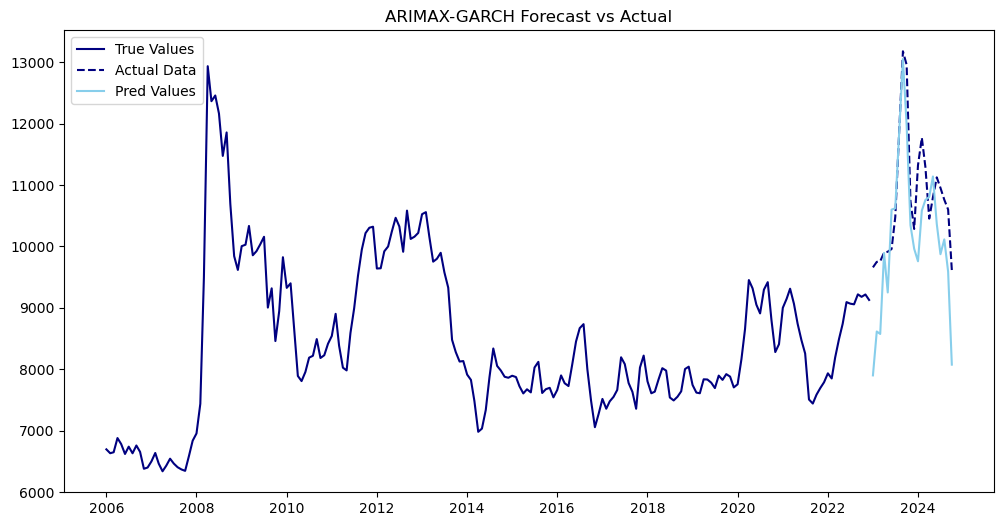

<Figure size 640x480 with 0 Axes>

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label="True Values")
plt.plot(y_test.index, y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(y_test.index, yhat, c='skyblue', label="Pred Values")
plt.legend()
plt.title("ARIMAX-GARCH Forecast vs Actual")
plt.show()
# saving the plot as an image
plt.savefig('../figure/ARIMAX-GARCH Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [52]:
# Assuming the variable name is "model," we can extract three key GARCH coefficients:
# omega: constant term
# alpha: ARCH term (impact of past squared returns)
# beta: GARCH term (persistence of volatility)

# Try something like this...
print('GARCH Coefficients:')
print('omega (constant):', arimax2_model.params['omega'])
print('alpha (ARCH term):', arimax2_model.params['alpha[1]'])
print('beta (GARCH term):', arimax2_model.params['beta[1]'])

GARCH Coefficients:


KeyError: 'omega'

In [ ]:
# Assuming the variable name is "model"

print('AR(1):', arimax2_model.params[1])  # AR coefficient
print('MA(1):', arimax2_model.params[2])  # MA coefficient


# Or possibly from your ARIMA(X):
print('AR(1):', arimax2_model.params['ar.L1'])     # AR coefficient
print('MA(1):', arimax2_model.params['ma.L1'])     # MA coefficient

for name in exog_df.columns:
    print(f'{name}:', arimax2_model.params[name])   # exog coefficients

# Compare the accuracy of models

In [54]:
accuracy_df = pd.concat([lr_accuracy,arimax2_accuracy,garch_accuracy])
accuracy_df

,model,accuracy,score
0,Linear,MSE,1.230137e+06
1,Linear,RMSE,1.109115e+03
2,Linear,R2,-3.069252e-01
0,"ARIMAX(2,0,0)",MSE,1.275763e+06
1,"ARIMAX(2,0,0)",RMSE,1.129497e+03
2,"ARIMAX(2,0,0)",R2,-3.553993e-01
0,GARCH,MSE,8.106684e+05
1,GARCH,RMSE,9.003713e+02
2,GARCH,R2,1.387277e-01


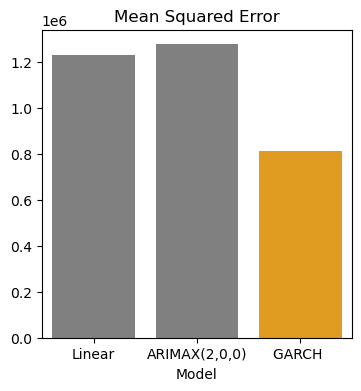

In [56]:
plt.figure(figsize=(4,4))
col = ['grey' if (x < max(accuracy_df[accuracy_df['accuracy'] == "MSE"])) else 'orange' for x in accuracy_df[accuracy_df['accuracy'] == "MSE"]]
ax = sns.barplot(accuracy_df[accuracy_df['accuracy'] == "MSE"],x="model", y="score",hue="model"\
            ,gap=0,palette=col).set(xlabel='Model', ylabel='')
plt.title('Mean Squared Error')
# saving the plot as an image
plt.savefig('../figure/Mean Squared Error.png')
plt.show()

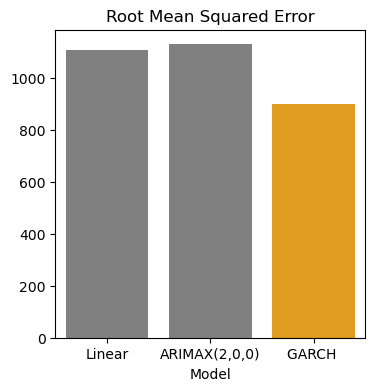

In [57]:
plt.figure(figsize=(4,4))
col = ['grey' if (x < max(accuracy_df[accuracy_df['accuracy'] == "RMSE"])) else 'orange' for x in accuracy_df[accuracy_df['accuracy'] == "RMSE"]]
ax = sns.barplot(accuracy_df[accuracy_df['accuracy'] == "RMSE"],x="model", y="score",hue="model"\
            ,gap=0,palette=col).set(xlabel='Model', ylabel='')
plt.title('Root Mean Squared Error')
# saving the plot as an image
plt.savefig('../figure/Root Mean Squared Error.png')
plt.show()

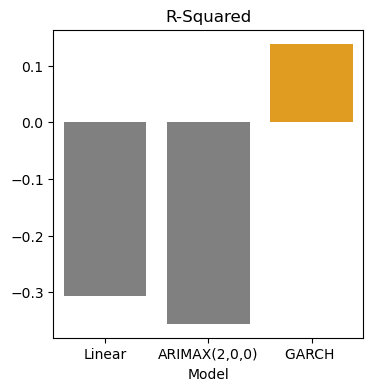

In [59]:
plt.figure(figsize=(4,4))
cols = ['grey' if (x < max(accuracy_df[accuracy_df['accuracy'] == "R2"])) else 'orange' for x in accuracy_df[accuracy_df['accuracy'] == "R2"]]
ax = sns.barplot(accuracy_df[accuracy_df['accuracy'] == "R2"],x="model", y="score",hue="model"\
            ,gap=0,palette=cols).set(xlabel='Model', ylabel='')
plt.title('R-Squared')
# saving the plot as an image
plt.savefig('../figure/R-Squared.png')
plt.show()